# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В нашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Целью этого проекта является построение модели для определения стоимости автомобиля на основании его характеристик. 

Критерии Заказчика:
- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

### Импорт библиотек и функций

In [1]:
!pip install --upgrade scikit-learn -q
#базовые
import pandas as pd
import numpy as np
#учет времени выполнения
import time
#генерация случайных чисел
import random
# отключение ошибок
import warnings
# графики
import seaborn as sns
import matplotlib.pyplot as plt
#анализ корреляции Phi_K 
!pip install phik -q
import phik
from phik import phik_matrix
from phik.report import plot_correlation_matrix
# преобразование данных
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
# Модели
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import RandomizedSearchCV
# Метрики
from sklearn.metrics import root_mean_squared_error
# пайплайны
from sklearn.pipeline import Pipeline
#проверка адекватности модели
from sklearn.dummy import DummyRegressor
#модели градиентного бустинга
import lightgbm as lgb
import catboost as cb

RANDOM_STATE = 88

In [2]:
#функция первичного анализа данных
def data_report(df, show_info=True):
    temp = df.copy() 
    col_list = temp.columns
    print('='* 90)
    if show_info == True:
        print(temp.info())
#Поиск нулевых значений
    counter = 0
    for column in col_list:
        if (temp[temp[column] == 0][column].count() > 0) | (
            temp[temp[column] == ' '][column].count() > 0):
            counter += 1
    print('-'* 90)    
    print(f'Столбцов с пустыми и нулевыми значениями: {counter}')
    print('-'* 90)    
    if counter > 0:
        print(f'Перечень столбцов с пустыми и нулевыми значениями:')
        print('-'* 45)
        print(f'{"Имя поля":<40}{"Кол-во значений":<25}{"Процент к общему":<25}')
        print('-'* 90)
        for column in col_list:
            if (temp[temp[column] == 0][column].count() > 0) | (
               temp[temp[column] == ' '][column].count() > 0):
                print(f'{column :<40}'
                      f'{temp[temp[column] == 0][column].count():<25}'
                      f'{temp[temp[column] == 0][column].count()/len(temp):.2%}')                
#Поиск пропусков
    counter = 0
    for column in col_list:
        if temp[column].isna().sum() > 0:
            counter += 1
    print('-'* 90)    
    print(f'Столбцов с пропусками: {counter}')
    print('-'* 90)    
    if counter > 0:
        print(f'Перечень столбцов с пропусками:')
        print('-'* 45)
        print(f'{"Имя поля":<40}{"Кол-во пропусков":<25}{"Процент к общему":<25}')
        print('-'* 90)
        for column in col_list:
            if temp[column].isna().sum() > 0:
                print(f'{column :<40}'
                      f'{temp[column].isna().sum():<25}'
                      f'{temp[column].isna().mean():.2%}')                
#Поиск явных дубликатов
    duplicates = temp.duplicated().sum()
    print('='* 90)
    print(f'Количество дубликатов по строкам: {duplicates}')
    print('='* 90)
    if duplicates > 0:
        print('Дублированные строки:')
        print('-'* 90)
        print(temp[temp.duplicated()==True][col_list[:3]])
        print('='* 90)
#Поиск неявных дубликатов
    string_columns = temp.select_dtypes(include='object').columns.tolist()
    print('Уникальные значения в тестовых полях')
    print('='* 90)
    for column in string_columns:
        values = temp[column].unique()
        if len(values) <= 25:
            print(f'{column}: {values}')
            print('-'* 90)
        else:
            print(f'В поле {column} слишком много значений')
            print('-'* 90)

In [3]:
#функция печати графиков для исследовательского анализа данных
def stat_plots(df, custom_bins={}, countplots=[]):
    for column in countplots:
        data = df[column]
        sns.countplot(data, palette='GnBu_r')
        plt.title(f'Количественный анализ дискретного признака {column}')
        plt.xlabel('Значения')
        plt.ylabel('Количество')
        plt.show()
    df = df.drop(countplots, axis=1)    
    for column in df.select_dtypes(include='number').columns:
        try:
            nbins = custom_bins[column]
        except:
            nbins = 10
        ind_label = df[column].name
        print('=' * 110)
        print(f'Статистический анализ показателя {ind_label}')
        print('-' * 110)
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
        bins = axes[0].hist(df[column], bins=nbins)
        axes[0].vlines(x=df[column].mean(), colors='red', ymin=0, ymax=bins[0].max(), label='Среднее')
        axes[0].vlines(x=df[column].median(), colors='red', ymin=0, ymax=bins[0].max(), linestyles='--', label='Медиана')
        axes[0].set_title('Гистограмма распределения')
        axes[0].set_xlabel(ind_label)
        axes[0].set_ylabel('Количество значений')
        axes[0].legend()
        axes[1].boxplot(df[column], vert=False)
        axes[1].set_title('Диаграмма размаха')
        axes[1].set_xlabel(ind_label)
        plt.show()
    for column in df.select_dtypes(include='object').columns:
        ind_label = df[column].name
        df[column].value_counts().plot(kind='pie', autopct='%.0f', subplots=True, legend=False, label=ind_label)
        plt.title(f'Распределение долей по показателю {ind_label}')
        plt.show()

In [4]:
#матрица корреляции phi_k
def phik_corr(df):
    size = len(df.columns) + 1
    phik_overview = phik_matrix(df)
    plot_correlation_matrix(
        phik_overview.values,
        x_labels=phik_overview.columns,
        y_labels=phik_overview.index,
        vmin=0, vmax=1, color_map='Greens',
        title=r'correlation $\phi_K$',
        fontsize_factor=1.5,
        figsize=(size, size)
    )

### Загрузка и предобработка данных

In [5]:
data = pd.read_csv('/datasets/autos.csv')

In [6]:
data_report(data)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

Заполним пропуски в данных

In [7]:
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [8]:
data.VehicleType = data.VehicleType.fillna('other')
data.Gearbox = data.Gearbox.fillna('not_specified')
data.Model = data.Model.fillna(data.Brand)
data.FuelType = data.FuelType.fillna('other')
data.Repaired = data.Repaired.fillna('not_specified')

In [9]:
data.groupby('Model')['VehicleType'].unique()

Model
100                [other, wagon, sedan, coupe, convertible]
145                             [other, small, sedan, coupe]
147                 [sedan, small, other, wagon, coupe, suv]
156                      [wagon, sedan, other, coupe, small]
159                                    [sedan, wagon, other]
                                 ...                        
yaris                      [small, other, bus, wagon, sedan]
yeti                                     [suv, other, wagon]
ypsilon                          [small, other, convertible]
z_reihe                   [convertible, coupe, other, sedan]
zafira     [other, bus, wagon, small, suv, sedan, convert...
Name: VehicleType, Length: 290, dtype: object

In [10]:
data.groupby('Model')['FuelType'].unique()

Model
100                     [petrol, gasoline, other, lpg]
145                          [petrol, other, gasoline]
147                     [gasoline, petrol, other, lpg]
156                     [petrol, lpg, gasoline, other]
159                          [other, gasoline, petrol]
                              ...                     
yaris                [petrol, other, gasoline, hybrid]
yeti                         [petrol, gasoline, other]
ypsilon                 [petrol, other, gasoline, lpg]
z_reihe                 [petrol, other, lpg, gasoline]
zafira     [gasoline, petrol, cng, other, lpg, hybrid]
Name: FuelType, Length: 290, dtype: object

Заменим неявные дубликаты

In [11]:
data.FuelType = data.FuelType.replace('petrol', 'gasoline')
data.VehicleType = data.VehicleType.replace('bus', 'wagon')
data.Model = data.Model.replace('rangerover', 'range_rover')

Частично удалим незначимые признаки, сохраняя уникальность записей для сброса явных дубликатов

In [12]:
data = data.drop(['NumberOfPictures', 'LastSeen', 'DateCrawled'], axis=1)

In [13]:
data = data.drop(data.Price[data.Price == 0].index)

Сбросим дубликаты

In [14]:
data = data.drop_duplicates().reset_index(drop=True)

Окончательно удалим незначимые признаки

Проверим результат

In [15]:
data_report(data)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 333580 entries, 0 to 333579
Data columns (total 13 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Price              333580 non-null  int64 
 1   VehicleType        333580 non-null  object
 2   RegistrationYear   333580 non-null  int64 
 3   Gearbox            333580 non-null  object
 4   Power              333580 non-null  int64 
 5   Model              333580 non-null  object
 6   Kilometer          333580 non-null  int64 
 7   RegistrationMonth  333580 non-null  int64 
 8   FuelType           333580 non-null  object
 9   Brand              333580 non-null  object
 10  Repaired           333580 non-null  object
 11  DateCreated        333580 non-null  object
 12  PostalCode         333580 non-null  int64 
dtypes: int64(6), object(7)
memory usage: 33.1+ MB
None
------------------------------------------------------------------------------------------
Столбцов с пустыми и н

### Исследовательский анализ данных

Исследуем и удалим аномалии

In [16]:
data.Price.describe()

count    333580.000000
mean       4534.380943
std        4508.183438
min           1.000000
25%        1200.000000
50%        2850.000000
75%        6500.000000
max       20000.000000
Name: Price, dtype: float64

In [17]:
data = data.drop(data.Price[data.Price < 350].index)

In [18]:
data.RegistrationYear.describe()

count    318227.000000
mean       2004.040317
std          67.849997
min        1000.000000
25%        1999.000000
50%        2003.000000
75%        2008.000000
max        9999.000000
Name: RegistrationYear, dtype: float64

In [19]:
data = data.drop(data.RegistrationYear[(data.RegistrationYear < 1990) | (data.RegistrationYear > 2016)].index)

In [20]:
data['year_created'] = pd.DatetimeIndex(data.DateCreated).year

In [21]:
data['month_created'] = pd.DatetimeIndex(data.DateCreated).month

In [22]:
data = data.drop(data[(data.year_created == data.RegistrationYear) & (data.month_created < data.RegistrationMonth)].index)

In [23]:
data = data.drop(data[(data.year_created == data.RegistrationYear) & (data.Kilometer > 10000)].index)

In [24]:
data.Power.describe()

count    289326.000000
mean        115.879859
std         180.982873
min           0.000000
25%          75.000000
50%         109.000000
75%         147.000000
max       20000.000000
Name: Power, dtype: float64

In [25]:
data['model_power'] = data.groupby('Model')['Power'].transform('median').astype('int32')
data.loc[(data.Power < 60) | (data.Power > 500), 'Power'] = np.nan
data.Power = data.Power.fillna(data.model_power)

In [26]:
data = data.drop(['RegistrationMonth', 'DateCreated', 'PostalCode', 'year_created', 'month_created'], axis=1)

**Изучим распределения данных**

Статистический анализ показателя Price
--------------------------------------------------------------------------------------------------------------


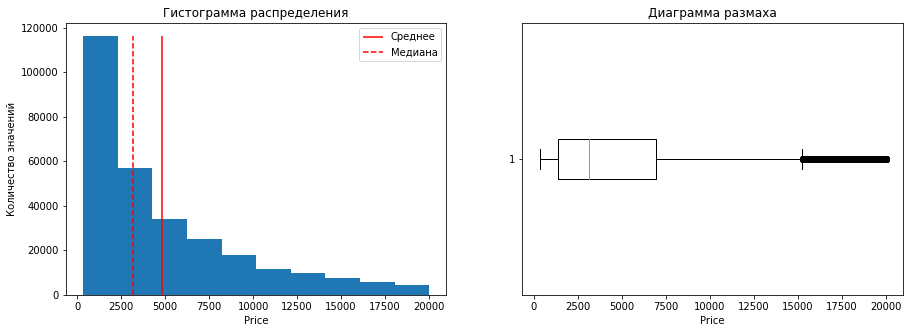

Статистический анализ показателя RegistrationYear
--------------------------------------------------------------------------------------------------------------


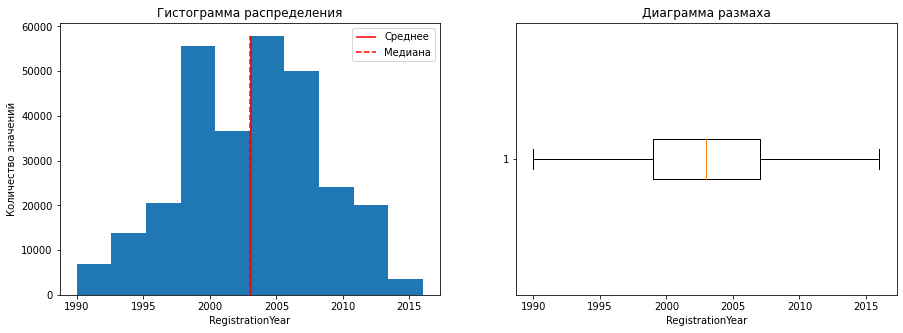

Статистический анализ показателя Power
--------------------------------------------------------------------------------------------------------------


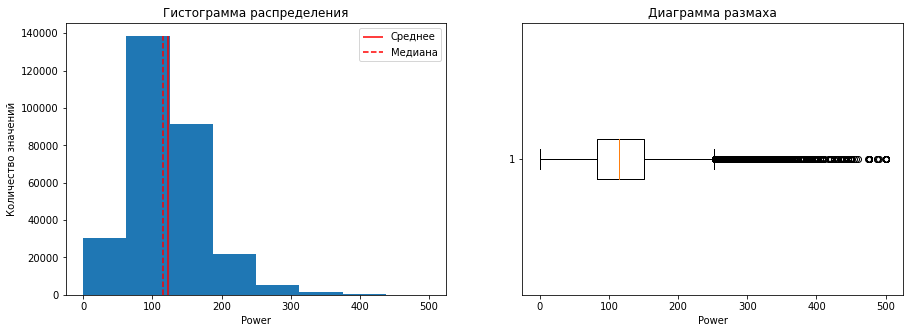

Статистический анализ показателя Kilometer
--------------------------------------------------------------------------------------------------------------


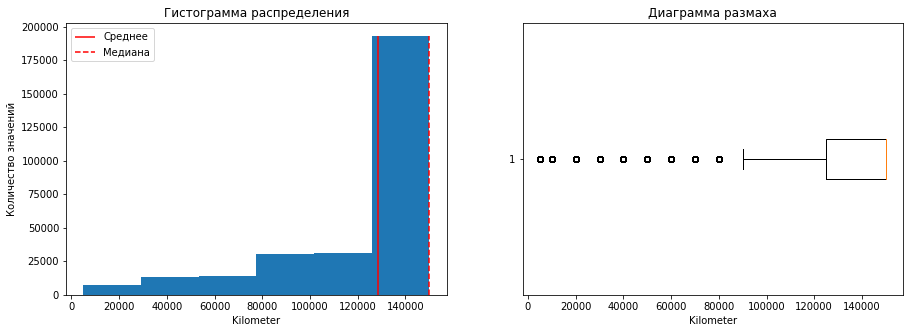

Статистический анализ показателя model_power
--------------------------------------------------------------------------------------------------------------


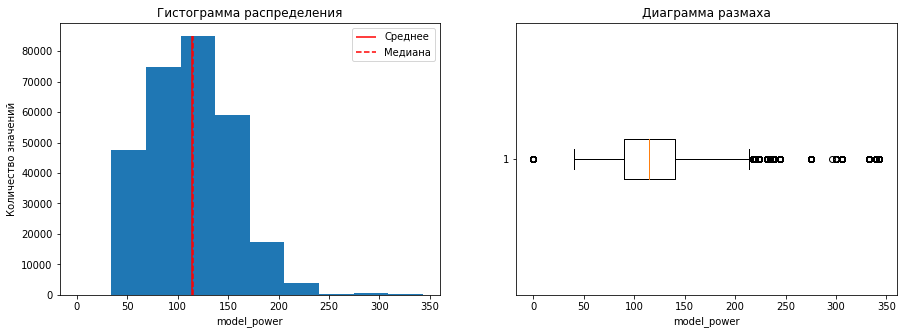

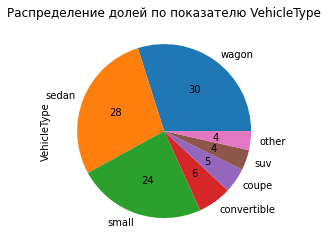

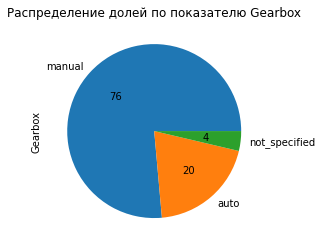

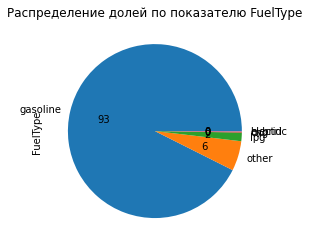

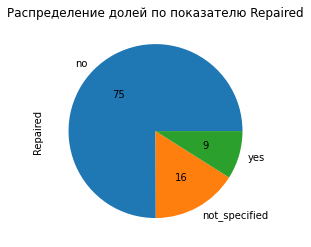

In [27]:
custom_bins = {
    'Kilometer': 6,
    'Power': 8
}
stat_plots(data.drop(['Model', 'Brand'], axis=1), custom_bins=custom_bins)

Данные распределены в основном ненормально, поэтому при анализе корреляций будем использовать корреляцию PhiK

### Анализ корреляций

interval columns not set, guessing: ['Price', 'RegistrationYear', 'Power', 'Kilometer', 'model_power']


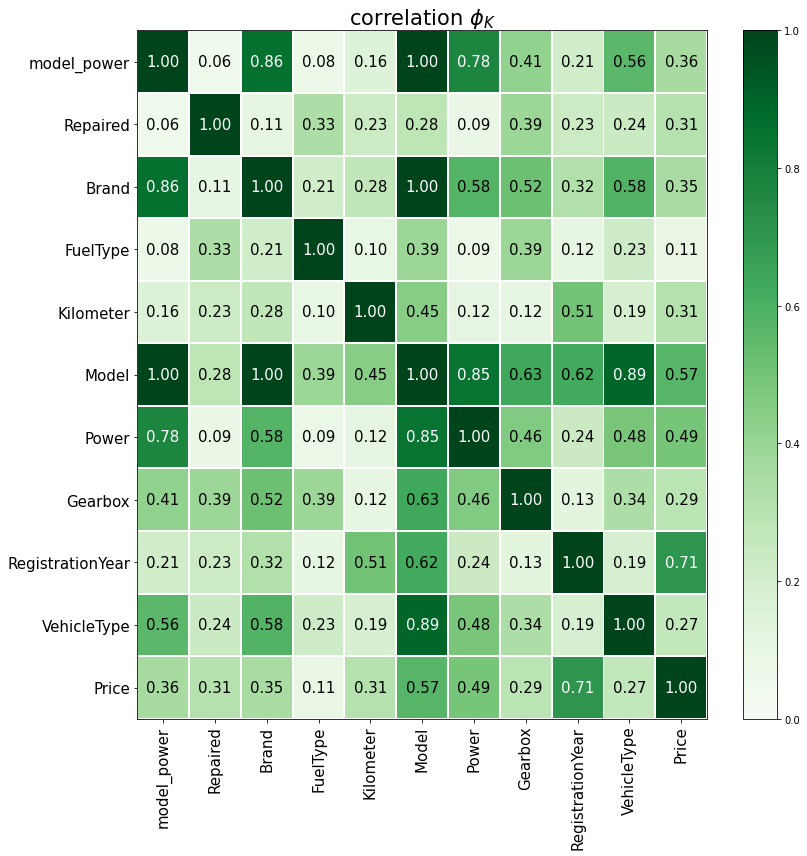

In [28]:
phik_corr(data)

Удалим признаки, вызывающие мультиколлинеарность:

In [29]:
data = data.drop(['VehicleType', 'Brand', 'FuelType'], axis=1)

## Обучение моделей

### Подготовка выборок

In [30]:
cat_features = data.select_dtypes(include='object').columns.tolist()
num_features = data.select_dtypes(include='number').columns.tolist()

**Сформируем два набора выборок для эмуляции вывода в прод**

In [31]:
train_data_prod, test_data_prod = train_test_split(data, test_size=0.2, random_state=RANDOM_STATE)
train_data, test_data = train_test_split(train_data_prod, test_size=0.2, random_state=RANDOM_STATE)

In [32]:
X_train_prod, y_train_prod = train_data_prod.drop('Price', axis=1), train_data_prod.Price
X_test_prod, y_test_prod = test_data_prod.drop('Price', axis=1), test_data_prod.Price

X_train, y_train = train_data.drop('Price', axis=1), train_data.Price
X_test, y_test = test_data.drop('Price', axis=1), test_data.Price

Создадим таблицу для учета результатов

In [33]:
results = pd.DataFrame(
    {
        'Model': [],
        'Fit_time': [],
        'Predict_time': [],
        'RMSE': []
    }
)

### Модель CatBoost

In [34]:
cb_train = cb.Pool(X_train, label=y_train, cat_features=cat_features)
cb_test = cb.Pool(X_test, cat_features=cat_features)

In [35]:
cb_model = cb.CatBoostRegressor(verbose=300, random_seed=RANDOM_STATE)

In [36]:
start = time.time()
cb_model.fit(cb_train)
end = time.time()
fit_time = int(end - start)
fit_minutes, fit_seconds = divmod(fit_time, 60)

Learning rate set to 0.093423
0:	learn: 4256.5652262	total: 220ms	remaining: 3m 39s
300:	learn: 1667.1859856	total: 32.7s	remaining: 1m 15s
600:	learn: 1613.7762027	total: 1m 4s	remaining: 42.8s
900:	learn: 1580.2140547	total: 1m 37s	remaining: 10.7s
999:	learn: 1571.5470130	total: 1m 48s	remaining: 0us


In [37]:
start = time.time()
y_pred = cb_model.predict(X_test)
end = time.time()
pred_time = round(end - start, 2)
pred_minutes, pred_seconds = divmod(pred_time, 60)

In [38]:
rmse = int(root_mean_squared_error(y_test, y_pred))
print(f'Время обучения модели CatBoost: {int(fit_minutes)} мин. {int(fit_seconds)} сек.')
print(f'Время предсказаний модели CatBoost: {int(pred_minutes)} мин. {int(pred_seconds)} сек.')
print(f'Значение метрики RMSE для модели CatBoost = {rmse}')

Время обучения модели CatBoost: 1 мин. 50 сек.
Время предсказаний модели CatBoost: 0 мин. 0 сек.
Значение метрики RMSE для модели CatBoost = 1628


In [39]:
results = results.append(
    {
        'Model': 'CatBoost',
        'Fit_time': fit_time,
        'Predict_time': pred_time,
        'RMSE': rmse
    }, ignore_index=True
)

### Модель LightGBM

In [40]:
X_train[cat_features] = X_train[cat_features].astype("category")
X_test[cat_features] = X_test[cat_features].astype("category")

In [41]:
lgb_train = lgb.Dataset(X_train, label=y_train)

depth = 10
leaves = 2 ** depth
leaf_data = 500

params = {
    'num_leaves': leaves,
    'min_data_in_leaf': leaf_data,
    'max_depth': depth,
    'learning_rate': 0.1,
    'num_iterations': 300,
    'verbose': -1, 
    'seed': RANDOM_STATE}

In [42]:
start = time.time()
lgb_model = lgb.train(params=params, train_set=lgb_train)
end = time.time()
fit_time = int(end - start)
fit_minutes, fit_seconds = divmod(fit_time, 60)

/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


In [43]:
start = time.time()
y_pred = lgb_model.predict(X_test)
end = time.time()
pred_time = round(end - start, 2)
pred_minutes, pred_seconds = divmod(pred_time, 60)

In [44]:
rmse = int(root_mean_squared_error(y_test, y_pred))
print(f'Время обучения модели LightGBM: {int(fit_minutes)} мин. {int(fit_seconds)} сек.')
print(f'Время получения предсказаний модели LightGBM: {int(pred_minutes)} мин. {int(pred_seconds)} сек.')
print(f'Значение метрики RMSE для модели LightGBM = {rmse}')

Время обучения модели LightGBM: 0 мин. 15 сек.
Время получения предсказаний модели LightGBM: 0 мин. 2 сек.
Значение метрики RMSE для модели LightGBM = 1601


In [45]:
results = results.append(
    {
        'Model': 'LightGBM',
        'Fit_time': fit_time,
        'Predict_time': pred_time,
        'RMSE': rmse
    }, ignore_index=True
)

### Модель Decision Tree

Подбор гиперпараметров методом RandomizedSearchCV

In [46]:
pipe_train =  Pipeline([
    ('preprocessor', OneHotEncoder(drop='first', handle_unknown='ignore')),
    ('models', 'passthrough')
])

In [47]:
param_grid = [
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__min_samples_split': range(2, 500),
        'models__min_samples_leaf': range(2, 500),
        'models__max_depth': range(2, 500),
        'models__max_features': range(2, 500)
    }   
]

In [48]:
param_search = RandomizedSearchCV(
    pipe_train,
    param_grid,
    n_jobs=-1,
    cv=5,
    n_iter=50,
    scoring='neg_root_mean_squared_error'
)

In [49]:
warnings.filterwarnings('ignore')

param_search.fit(X_train, y_train)

pd.set_option('display.max_colwidth', None)
result = pd.DataFrame(param_search.cv_results_)
result[['rank_test_score', 'params']].sort_values('rank_test_score').head(5)

,rank_test_score,params
31,1,"{'models__min_samples_split': 97, 'models__min_samples_leaf': 5, 'models__max_features': 425, 'models__max_depth': 363, 'models': DecisionTreeRegressor(random_state=88)}"
9,2,"{'models__min_samples_split': 6, 'models__min_samples_leaf': 22, 'models__max_features': 409, 'models__max_depth': 34, 'models': DecisionTreeRegressor(random_state=88)}"
37,3,"{'models__min_samples_split': 424, 'models__min_samples_leaf': 18, 'models__max_features': 273, 'models__max_depth': 241, 'models': DecisionTreeRegressor(random_state=88)}"
49,4,"{'models__min_samples_split': 371, 'models__min_samples_leaf': 43, 'models__max_features': 325, 'models__max_depth': 425, 'models': DecisionTreeRegressor(random_state=88)}"
15,5,"{'models__min_samples_split': 105, 'models__min_samples_leaf': 52, 'models__max_features': 242, 'models__max_depth': 147, 'models': DecisionTreeRegressor(random_state=88)}"


In [50]:
best_suite = param_search.best_estimator_
start = time.time()
best_suite.fit(X_train, y_train)
end = time.time()
fit_time = int(end - start)
fit_minutes, fit_seconds = divmod(fit_time, 60)

In [51]:
start = time.time()
y_pred = best_suite.predict(X_test)
end = time.time()
pred_time = round(end - start, 2)
pred_minutes, pred_seconds = divmod(pred_time, 60)

In [52]:
rmse = int(root_mean_squared_error(y_test, y_pred))
print(f'Время обучения лучшей модели Decision Tree: {int(fit_minutes)} мин. {int(fit_seconds)} сек.')
print(f'Время получения предсказаний лучшей модели Decision Tree: {int(pred_minutes)} мин. {int(pred_seconds)} сек.')
print(f'Значение метрики RMSE для модели Decision Tree после подбора параметров методом RandomizedSearchCV = {rmse}')

Время обучения лучшей модели Decision Tree: 0 мин. 5 сек.
Время получения предсказаний лучшей модели Decision Tree: 0 мин. 0 сек.
Значение метрики RMSE для модели Decision Tree после подбора параметров методом RandomizedSearchCV = 1947


In [53]:
results = results.append(
    {
        'Model': 'Decision_Tree',
        'Fit_time': fit_time,
        'Predict_time': pred_time,
        'RMSE': rmse
    }, ignore_index=True
)

### Dummy модель

In [54]:
dr = DummyRegressor(strategy='median')
dr.fit(X_train, y_train)
y_pred_dummy = dr.predict(X_test)
rmse = int(root_mean_squared_error(y_test, y_pred_dummy))
print(f'Значение метрики RMSE у DummyRegressor: {rmse}')

Значение метрики RMSE у DummyRegressor: 4859


Ошибка модели, предсказывающей случайные значения, в несколько раз превышает ошибки сравниваемых моделей.\
Это значит, что модели настроены адекватно задаче.

## Анализ моделей

По результатам произведенных экспериментов получены следующие результаты:

In [55]:
results = results.set_index('Model')
results.sort_values(by='RMSE')

,Fit_time,Predict_time,RMSE
Model,,,
LightGBM,15.0,2.11,1601.0
CatBoost,110.0,0.22,1628.0
Decision_Tree,5.0,0.09,1947.0


Наименьший размер ошибки демонстрирует модель LightGBM. При этом, схожую величину ошибки мы можем наблюдать и у модели CatBoost.\
Второй по значимости критерий качества Заказчика это время обучения, и оно значительно меньше у модели LightGBM относительно CatBoost. Минимальное время обучения и предсказания показала модель Decision_Tree, но она существенно проигрывает по первичному критерию, поэтому при дальнейшем сравнении мы ее уже не рассматриваем.\
Третий критерий Заказчика - это время предсказания, по которому имеет единственное преимущество модель CatBoost.\
**В итоге, наилучшие показатели по результатам сравнения продемонстрировала модель LightGBM.**\
Проверим ее метрики на тестовых данных:

In [59]:
X_test_prod[cat_features] = X_test_prod[cat_features].astype("category")
y_pred_prod = lgb_model.predict(X_test_prod)
rmse = int(root_mean_squared_error(y_test_prod, y_pred_prod))
print(f'Значение метрики RMSE для модели LightGBM на тестовых производственных данных = {rmse}')

Значение метрики RMSE для модели LightGBM на тестовых производственных данных = 2395


Как мы можем видеть, выбранная модель держит ключевую метрику в пределах норматива Заказчика на тестовых данных, что подтверждает наш выбор.

## Итоговый вывод

Набор данных, предоставленный для исследования, содержит множество пропусков, нулевых значений и аномалий.\
Для приведения данных в пригодное для обучения состояние были произведены следующие работы:
* Пропуски в полях VehicleType, Gearbox, FuelType и Repaired были заменены на значения по-умолчанию 
* Пропуски в поле Model были заменены на наименование бренда
* Устранены неявные дубликаты в полях Model, VehicleType и FuelType
* Исключены из моделирования строки с нулевой ценой
* Удалены явно дублированные записи

Исследовательский анализ данных показал ряд аномалий, которые были устранены, в частности:
* слишком низкие цены
* некорректные данные о годе выпуска автомобиля
* несоответствие дат публикации, года выпуска и пробега
* исправлены заведомо неверные данные о мощности автомобиля

Анализ распределений показал отсутствие нормальности распределений большинства признаков, в связи с чем для анализа корреляций была использована матрица PhiK.\
Анализ корреляций, в свою очередь, показал наличие взаимозависимых признаков, вплоть до мультиколлинеарности. Признаки с сильной зависимостью на другие входные признаки, были удалены.

Для целей проекта были задействованы три модели:
- CatBoost
- LightGBM
- Decision Tree

По результатам произведенных экспериментов получены следующие результаты:
* все модели показали точность согласно требованиям заказчика
* самая высокая точность отмечена у моделей CatBoost и LightGBM 
* при этом скорость обучения среди лидеров по точности выше у модели LightGBM
* скорость предсказаний, напротив - выше у модели CatBoost
* самое низкое время получения предсказаний продемонстрировала модель Decision Tree, наряду с самой низкой точностью

Таким образом, если для работы приложения важнее скорость обучения, то рекомендуется использовать модель LightGBM.
Если же важнее скорость получения предсказаний, то следует выбрать CatBoost.